# Price Predictor Parameter Optimisation

In [1]:
import src.utils.file_management as filemgmt
import src.pipeline.preprocessing as prep

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Literal, Union

from tqdm import tqdm
from alpha_vantage.timeseries import TimeSeries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from matplotlib.lines import Line2D
    
import matplotlib.pyplot as plt

In [2]:
ROOT = Path().resolve().parent

DATA = ROOT / "data"
DAILY_PRICES = DATA / "daily_price_downloads"
MINUTELY_PRICES = DATA / "minutely_price_downloads"
INTERPOLATED_PRICES = DATA / "interpolated_prices"

SAVED_MODELS = DATA / "saved_models"

## Class Setup

In [3]:
class TimeSeriesDataset(Dataset):
    """ Time-series dataset class based on torch.utils.data.Dataset compatible torch.utils.data.DataLoader """
    def __init__(self,
                 x: Union[pd.DataFrame, pd.Series, np.ndarray],
                 y: Union[pd.Series, pd.Series, np.ndarray],
                 verbose=False):
        # convert values to numpy if necessary:
        if isinstance(x, (pd.Series, pd.DataFrame)):
            x = x.to_numpy()
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.to_numpy()
            
        # expand tensor for LSTM input w. shape (batch, sequence_length, input_size):
        x = np.expand_dims(x, 2)
        
        # sanity check:
        if x.shape[0] != y.shape[0]: raise ValueError("Mismatched number of samples.")
        
        # save values:
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
        # information:
        if verbose: print(f"Dataset Shape: {self.x.shape}, {self.y.shape}")
        
    # necessary operators:
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    
class LSTMModel(nn.Module):
    """ LSTM model class based on torch.nn.Module """
    def __init__(self,
                 input_size=1,
                 hidden_layer_size=32,
                 num_layers=2,
                 n_forecast_steps=1,  # output sequence length
                 dropout=0.2,
                 use_pre_lstm_fc_layer=False,
                 use_final_hidden_state=True,
                 use_hidden_states_across_forecast_steps=True,
                 init_weights=True):
        """
        Initialise the LSTM model. 
        
        :param input_size: input size of the LSTM model.
        :param hidden_layer_size: hidden size of the LSTM model.
        :param num_layers: number of LSTM layers.
        :param n_forecast_steps: number of forecast steps. If not 1, outputs will be calculated recursively for each forecast step, i.e. while feeding back previous predictions into the network.
        """
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.use_pre_lstm_fc_layer = use_pre_lstm_fc_layer
        self.use_hidden_states_across_forecast_steps = use_hidden_states_across_forecast_steps
        self.n_forecast_steps = n_forecast_steps

        # optional pre-lstm fully connected layer:
        self.linear_1 = nn.Linear(input_size, hidden_layer_size) if use_pre_lstm_fc_layer else None  # transform feature into size of lstm hidden layers
        self.relu = nn.ReLU() if use_pre_lstm_fc_layer else None  # non-linearity

        # lstm layers:
        self.lstm = nn.LSTM(hidden_layer_size if use_pre_lstm_fc_layer else 1, hidden_size=self.hidden_layer_size, num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)  # batch first=True because our shape is (batch, seq, feature)
        # self.dropout = nn.Dropout(dropout)  # prevent overfitting, now is included in lstm

        self.use_final_hidden_state = use_final_hidden_state  # use lstm_out, else use h_n; see comments below in forward()

        # final fully connected layer:
        self.linear_2 = nn.Linear((num_layers if use_final_hidden_state else 1) * hidden_layer_size,
                                  1)  # transforms LSTM output into 1 price
        # when use_final_hidden_state, multiply with * num_layers to utilise all LSTM layer's final hidden states

        if init_weights: self.init_weights()  # empirically accelerates convergence

    def init_weights(self):
        for name, param in self.named_parameters():  # iterate through weights and biases
            if 'bias' in name:  # bias zero initialisation: neutral starting point
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:  # input-hidden weights with He/Kaiming initialisation w. normal distribution: preserves gradient magnitude through ReLU activations
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:  # hidden-hidden weights with orthogonal matrix initialisation: maintains norm during sequence processing and helps prevent gradient issues
                nn.init.orthogonal_(param)

    def forward(self, x):
        """ Forward call of module """
        batchsize = x.shape[0]
        
        outputs = torch.empty(size=(batchsize, self.n_forecast_steps), device=x.device, dtype=x.dtype)  # initialise empty tensor for outputs
        
        # recursive prediction (taking into account previous predictions if n_forecast_steps > 1):
        if self.use_hidden_states_across_forecast_steps:
            h_n, c_n = None, None  # initialise hidden cell states that will be used across steps to reduce computational complexity
            # this is favourable, because otherwise the complete sequence is reprocessed each iteration
            # and LSTMs are designed to remember previous steps through hidden states
        for output_sequence_ind in range(self.n_forecast_steps):
            # integrate previous predictions into input:
            if output_sequence_ind > 0:
                x = torch.roll(x, shifts=-1)  # shift all inputs back by one time unit
                x[:, -1] = torch.unsqueeze(outputs[:, output_sequence_ind-1], 1)  # replace most recent time step with last prediction
                
            if self.use_pre_lstm_fc_layer:
                # layer 1:
                temp_x = self.linear_1(x)  # we need to denote this as temp_x because we need the original input again in latter iterations
                # x = self.batch_norm(x)
                temp_x = self.relu(temp_x)
                # x.shape now is (batch, sequenth_length, features)
    
            # LSTM layer(s):
            if self.use_hidden_states_across_forecast_steps:
                # pass last hidden states again to lstm and compute only most recent step
                if h_n is None:  # first iteration
                    lstm_out, (h_n, c_n) = self.lstm(temp_x)  # compute first step and get hidden and cell states
                else:  # further iterations
                    lstm_out, (h_n, c_n) = self.lstm(temp_x[:, -1].unsqueeze(1), (h_n, c_n))  # compute new information and leverage previous hidden and cell states
            else:
                lstm_out, (h_n, c_n) = self.lstm(temp_x)
    
            # which output to use?
            # - lstm_out contains **all hidden states for the last layer** for every time step, used for tasks requiring per-time-step predictions and **sequence forecasting**
            #       shape is (batchsize, sequence_length, features)
            # - h_n is a tensor containing the **final hidden state for each layer** in the sequence, used for initialing latter sequences, as summarisation for classification tasks or **one-step-forecasting**
            #       shape is (num_layers, batchsize, features)
            # - c_n is a tensor containing the **final cell state for each layer** in the sequence, used jointly with h_n for more complex forecasting purposes
            #       shape is (num_layers, batchsize, features)
            if self.use_final_hidden_state:
                # we utilise h_n because it aggregates states from all layers.
                # reshape final hidden state output from (num_layers, batchsize, features) to (batchsize, features) for consecutive linear layer:
                # permute rearranges the dimensions according to a specific order, -1 tells reshape to infer the correct size for that dimension
                temp_x = h_n.permute(1, 0, 2).reshape(batchsize, -1)  # here we flatten all layer outputs
            else:
                # we utilise lstm_out[:, -1, :]  which is the last time step of the final layer
                temp_x = lstm_out[:, -1, :]
    
            # layer 2:
            # x = self.dropout(x)  additional regularisation is spared here because happening inside LSTM
            predictions = self.linear_2(temp_x)
            outputs[:, output_sequence_ind] = predictions.squeeze(-1)  # return last column of all batches (equals predictions), squeeze removes dimensions with size 1
        
        return outputs.squeeze(-1)  # remove dimensions with size 1

    def run_epoch(self, dataloader, optimiser, device='cpu', loss_criterion=nn.MSELoss(), is_training=False):
        """ One epoch of training (is_training=True) or validation (is_training=False), returns the respective loss and learning rate as tuple. """
        epoch_loss = 0

        if is_training:
            self.train()  # training mode activates Dropout and BatchNorm (updates running statistics with each batch)
        else:
            self.eval()  # evaluation mode for inference or testing

        # iterate through dataset's batches via provided dataloader instance:
        for idx, (x, y) in enumerate(dataloader):
            if is_training: optimiser.zero_grad()  # reset all gradients for next training step

            # move tensors to correct device:
            x = x.to(device)
            y = y.to(device)

            # compute output and loss:
            out = self(x)
            loss = loss_criterion(out.contiguous(),
                                  y.contiguous())  # enforces the tensors to be stored in a contiguous memory block

            if is_training:
                loss.backward()  # backpropagation, traverses computational graph in reverse applying the chain rule to compute gradients
                optimiser.step()  # optimise weights

            epoch_loss += loss.detach().item()  # without / batchsize because loss is already averaged, detach loss value from computational graph

        # learning rate:
        lr = optimiser.param_groups[0]['lr']

        return epoch_loss, lr

    def predict(self, dataloader, device='cpu'):
        """ Compute predictions (outputs) for all samples in a dataloader. """
        self.eval()  # inference mode
        
        # deactivate shuffling and set batch size to 1:
        temp_loader = DataLoader(dataloader.dataset, batch_size=1, shuffle=False)
        
        # compute predictions:
        with torch.no_grad():
            for idx, (x, y) in enumerate(tqdm(temp_loader)):
                x = x.to(device)
                out = self(x)  # run model
                out = out.cpu().detach().numpy()
                if idx == 0: predictions = np.array(out); continue  # initialise array upon first iteration
                predictions = np.concat((predictions, out))

            return predictions


class WeightedMSELoss(nn.Module):
    def __init__(self, step_weights=None):
        """ Weighted MSE Loss. If step_weights is None, weights all predictions equally. """
        super().__init__()
        self.step_weights = step_weights
        
    def forward(self, predictions, targets):
        # predictions and target shape: [batch_size, n_steps]
        if self.step_weights is None:  # equal weighting
            return torch.mean((predictions - targets) ** 2)  # MSE formula
        else:  # weighted loss
            losses = (predictions - targets) ** 2
            weighted_losses = losses * torch.Tensor(self.step_weights, device=predictions.device)  # calculate weighted loss tensor
            return torch.mean(weighted_losses)


class Normaliser():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        """ Normalise an array of values. """
        self.mu = np.mean(x, axis=0)
        self.sd = np.std(x, axis=0)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def transform(self, x):
        """ Normalise additional data of same sequence as before. """
        if self.sd is None: raise AttributeError("Please use fit_transform first so this instance remembers the respective std. and mean values!")
        normalized_x = (x - self.mu)/self.sd
        return normalized_x
        
    def inverse_transform(self, x):
        """ Reverse-transform an array of normalised values. """
        if self.sd is None: raise AttributeError("Please use fit_transform first so this instance remembers the respective std. and mean values!")
        return (x*self.sd) + self.mu
    

class LSTMPredictor:
    """ LSTM based stock price predictor framework. """
    def __init__(self,
                 sampling_rate_minutes: int = 15,  # data import parameters
                 price_csv_path: str = None,
                 price_column: str = 'close',
                 date_column: str = 'date',
                 daily_prediction_hour: int = None,  # data preparation parameters
                 rolling_window_size: int = 32,
                 forecast_horizon: int = 12,
                 validation_split: float = 0.2,
                 batch_size: int = 32,
                 model_load_file_path: str = None,  # model parameters
                 hidden_lstm_layer_size: int = 64,
                 n_lstm_layers: int = 3,
                 dropout: float = 0.2,
                 use_final_hidden_state: bool = False,
                 use_pre_lstm_fc_layer: bool = True,
                 init_weights: bool = True,
                 use_mps_if_available: bool = False,
                 model_save_directory: str = None,
                 forecast_step_loss_weight_range: (float) = (1, 0.7),  # training parameters
                 n_train_epochs: int = None,  # if set to some number, trains upon initialisation
                 lr_scheduler: Literal['step', 'plateau'] = 'plateau',
                 initial_lr: float = 0.001,
                 step_scheduler_step_size: int = 40,
                 plateau_scheduler_factor: float = 0.5,
                 early_stopping_patience: int = 30,  # if 0 doesn't utilise early stopping
                 verbose = True,  # other parameters
                 ):
        self._sampling_rate_minutes = sampling_rate_minutes
        self._price_csv_path = price_csv_path
        self._price_column = price_column
        self._date_column = date_column
        
        self._daily_prediction_hour = daily_prediction_hour
        self._rolling_window_size = rolling_window_size
        self._forecast_horizon = forecast_horizon
        self._validation_split = validation_split
        self._batch_size = batch_size
        
        if model_load_file_path is not None: self.load_model_from_pt_file(model_load_file_path)
        self._hidden_lstm_layer_size = hidden_lstm_layer_size
        self._n_lstm_layers = n_lstm_layers
        self._dropout = dropout
        self._use_final_hidden_state = use_final_hidden_state
        self._use_pre_lstm_fc_layer = use_pre_lstm_fc_layer
        self._init_weights = init_weights
        self._use_mps_if_available = use_mps_if_available
        
        self.model_save_directory = model_save_directory
        self._forecast_step_loss_weight_range = forecast_step_loss_weight_range
        self._n_train_epochs = n_train_epochs
        self._lr_scheduler = lr_scheduler
        self._initial_lr = initial_lr
        self._step_scheduler_step_size = step_scheduler_step_size
        self._plateau_scheduler_factor = plateau_scheduler_factor
        self._early_stopping_patience = early_stopping_patience
        
        self.verbose = verbose
        
        self._price_series = self._normalised_price_series = None
        self._normaliser = Normaliser()
        self._X = self._Y = self._X_dates = self._Y_dates = None
        self._X_train = self._X_val = self._Y_train = self._Y_val = self._X_dates_train = self._X_dates_val = self._Y_dates_train = self._Y_dates_val = None
        self._dataloader_train = self._dataloader_val = None
        
        self._lstm_model = None
        self._device = None
        self._loss_criterion = None
        
        self._predictions_train = self._predictions_val = None
        
        if price_csv_path is None and verbose: print('No price file provided yet. Define LSTMPredictor.price_csv_path to trigger data import.')
        if daily_prediction_hour is None and verbose: print('No daily prediction hour defined yet, hence currently predictions are carried out at every time step. Define LSTMPredictor.daily_prediction_hour to change this.')
        if n_train_epochs is None and verbose: print('No training epochs defined upon initialisation. Define LSTMPredictor.n_train_epochs to start training procedure.')
        elif n_train_epochs is not None:  # automatically start training
            self.run_training()
            if verbose:
                print('Training finished. Plotting results for validation split:')
                self.plot_prediction_overview(day_slice=(0, 5))
    
    # data import parameters:
    @property
    def sampling_rate_minutes(self): return self._sampling_rate_minutes

    @property
    def price_csv_path(self): return self._price_csv_path
    
    @price_csv_path.setter
    def price_csv_path(self, value): self._price_csv_path = value; self.import_data()
    
    @property
    def price_column(self): return self._price_column
    
    @price_column.setter
    def price_column(self, value):
        self._price_column = value
        if self._price_series is not None: self._price_series.name = value

    @property
    def date_column(self): return self._date_column
    
    @date_column.setter
    def date_column(self, value):
        self._date_column = value
        if self._price_series is not None: self._price_series.index.name = value
            
    @property
    def price_series(self):
        if self._price_series is None:
            if self.price_csv_path is None: raise AttributeError("LSTMPredictor.price_csv_path needs to be provided to import price data.")
            else: self.import_data()
        return self._price_series
            
    # data preparation parameters:
    @property
    def normalised_price_series(self):
        if self._normalised_price_series is None:
            self._normalised_price_series = self._normaliser.fit_transform(self.price_series)
        return self._normalised_price_series
    
    @property
    def daily_prediction_hour(self): return self._daily_prediction_hour

    @daily_prediction_hour.setter
    def daily_prediction_hour(self, value): self._daily_prediction_hour = value; self.prepare_data()
    
    @property
    def rolling_window_size(self): return self._rolling_window_size
    
    @rolling_window_size.setter
    def rolling_window_size(self, value): self._rolling_window_size = value; self.prepare_data()

    @property
    def forecast_horizon(self): return self._forecast_horizon
    
    @forecast_horizon.setter
    def forecast_horizon(self, value): self._forecast_horizon = value; self.prepare_data()
    
    @property
    def X(self):
        if self._X is None: self.prepare_data()
        return self._X
    
    @property
    def Y(self):
        if self._Y is None: self.prepare_data()
        return self._Y
    
    @property
    def X_dates(self):
        if self._X_dates is None: self.prepare_data()
        return self._X_dates
    
    @property
    def Y_dates(self):
        if self._Y_dates is None: self.prepare_data()
        return self._Y_dates
    
    @property
    def validation_split(self): return self._validation_split
    
    @validation_split.setter
    def validation_split(self, value): self._validation_split = value; self.split_data()
    
    @property
    def X_train(self):
        if self._X_train is None: self.split_data()
        return self._X_train

    @property
    def X_val(self):
        if self._X_val is None: self.split_data()
        return self._X_val

    @property
    def Y_train(self):
        if self._Y_train is None: self.split_data()
        return self._Y_train

    @property
    def Y_val(self):
        if self._Y_val is None: self.split_data()
        return self._Y_val

    @property
    def X_dates_train(self):
        if self._X_dates_train is None: self.split_data()
        return self._X_dates_train

    @property
    def X_dates_val(self):
        if self._X_dates_val is None: self.split_data()
        return self._X_dates_val

    @property
    def Y_dates_train(self):
        if self._Y_dates_train is None: self.split_data()
        return self._Y_dates_train

    @property
    def Y_dates_val(self):
        if self._Y_dates_val is None: self.split_data()
        return self._Y_dates_val
    
    @property
    def dataset_train(self):
        return TimeSeriesDataset(self.X_train, self.Y_train)
    
    @property
    def dataset_val(self):
        return TimeSeriesDataset(self.X_val, self.Y_val)
    
    @property
    def batch_size(self): return self._batch_size
    
    @batch_size.setter
    def batch_size(self, value):
        """ Changing value re-initialises dataloaders. """
        self._batch_size = value
        self._dataloader_train = self._dataloader_val = None
    
    @property
    def dataloader_train(self):
        if self._dataloader_train is None: self._dataloader_train = DataLoader(self.dataset_train, batch_size=self.batch_size, shuffle=True)
        return self._dataloader_train
        
    @property
    def dataloader_val(self):
        if self._dataloader_val is None: self._dataloader_val = DataLoader(self.dataset_val, batch_size=self.batch_size, shuffle=True)
        return self._dataloader_val
        
    # model parameters:
    @property
    def hidden_lstm_layer_size(self): return self._hidden_lstm_layer_size
    
    @hidden_lstm_layer_size.setter
    def hidden_lstm_layer_size(self, value):
        """ Changing value re-initialises LSTM model. """
        self._hidden_lstm_layer_size = value
        self._lstm_model = None
    
    @property
    def n_lstm_layers(self): return self._n_lstm_layers
    
    @n_lstm_layers.setter
    def n_lstm_layers(self, value):
        """ Changing value re-initialises LSTM model. """
        self._n_lstm_layers = value
        self._lstm_model = None
    
    @property
    def dropout(self): return self._dropout
    
    @dropout.setter
    def dropout(self, value):
        """ Changing value re-initialises LSTM model. """
        self._dropout = value
        self._lstm_model = None
        
    @property
    def use_final_hidden_state(self): return self._use_final_hidden_state

    @use_final_hidden_state.setter
    def use_final_hidden_state(self, value):
        """ Changing value re-initialises LSTM model. """
        self._use_final_hidden_state = value
        self._lstm_model = None

    @property
    def use_pre_lstm_fc_layer(self): return self._use_pre_lstm_fc_layer

    @use_pre_lstm_fc_layer.setter
    def use_pre_lstm_fc_layer(self, value):
        """ Changing value re-initialises LSTM model. """
        self._use_pre_lstm_fc_layer = value
        self._lstm_model = None

    @property
    def init_weights(self): return self._init_weights

    @init_weights.setter
    def init_weights(self, value):
        """ Changing value re-initialises LSTM model. """
        self._init_weights = value
        self._lstm_model = None
    
    @property
    def lstm_model(self):
        if self._lstm_model is None:
            self._lstm_model = LSTMModel(input_size=1, hidden_layer_size=self.hidden_lstm_layer_size,
                                         num_layers=self._n_lstm_layers, n_forecast_steps=self.forecast_horizon,
                                         dropout=self.dropout, use_pre_lstm_fc_layer=self.use_pre_lstm_fc_layer,
                                         use_final_hidden_state=self.use_final_hidden_state,
                                         use_hidden_states_across_forecast_steps=True,
                                         init_weights=self.init_weights)
            self._lstm_model.to(self.device)
            self._lstm_model = torch.compile(self._lstm_model)
        return self._lstm_model
    
    @lstm_model.setter
    def lstm_model(self, value):
        self._lstm_model = value
        # set other properties based on model parameters:
        try:
            a = value.linear_1  # try accessing layer
            self._use_pre_lstm_fc_layer = True if a is not None else False
        except AttributeError:  # if not found
            self._use_pre_lstm_fc_layer = False
        self._hidden_lstm_layer_size = value.lstm.hidden_size
        self._n_lstm_layers = value.lstm.num_layers
        self._dropout = value.lstm.dropout
    
    @property
    def use_mps_if_available(self): return self._use_mps_if_available
    
    @use_mps_if_available.setter
    def use_mps_if_available(self, value):
        """ Changing value re-initialises device. """
        self._use_mps_if_available = value; self._device = None; self._lstm_model.to(self.device)
        
    @property
    def device(self):
        if self._device is None:
            if torch.cuda.is_available():
                self._device = torch.device('cuda')  # if ROCm is installed and AMD hardware is supported by such then 'cuda' also refers to AMD GPU acceleration. This however is not possible on mac
                if self.verbose: print("Using GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))
            elif torch.backends.mps.is_available() and self.use_mps_if_available:
                self._device = torch.device('mps')
                if self.verbose: print("Using GPU through Metal Performance Shaders (MPS) backend")
            else:
                self._device = torch.device('cpu')
                if self.verbose: print("Using CPU")
        return self._device
    
    # training parameters:
    @property
    def forecast_step_loss_weight_range(self): return self._forecast_step_loss_weight_range
    
    @forecast_step_loss_weight_range.setter
    def forecast_step_loss_weight_range(self, value):
        """ Changing value re-initialises loss criterion. """
        self._forecast_step_loss_weight_range = value; self._loss_criterion = None
    
    @property
    def loss_criterion(self):
        """ Forecast step loss weighted according to LSTMPredictor.forecast_step_loss_weight_range. """
        if self._loss_criterion is None: self._loss_criterion = WeightedMSELoss(step_weights=np.linspace(self.forecast_step_loss_weight_range[0],
                                                                                                         self.forecast_step_loss_weight_range[1],
                                                                                                         self.forecast_horizon))
        return self._loss_criterion
    
    @property
    def n_train_epochs(self): return self._n_train_epochs

    @n_train_epochs.setter
    def n_train_epochs(self, value): self._n_train_epochs = value; self.run_training()
    
    @property
    def lr_scheduler(self): return self._lr_scheduler

    @property
    def initial_lr(self): return self._initial_lr

    @property
    def step_scheduler_step_size(self): return self._step_scheduler_step_size

    @property
    def plateau_scheduler_factor(self): return self._plateau_scheduler_factor

    @property
    def early_stopping_patience(self): return self._early_stopping_patience
    
    @property
    def predictions_train(self):
        if self._predictions_train is None:
            self._predictions_train = self._lstm_model.predict(self.dataloader_train, device=self.device)
        return self._predictions_train
    
    @property
    def predictions_val(self):
        if self._predictions_val is None:
            self._predictions_val = self._lstm_model.predict(self.dataloader_val, device=self.device)
        return self._predictions_val
    
    def import_data(self):
        """ Import data from LSTMPredictor.price_csv_path file. """
        price_file = pd.read_csv(self._price_csv_path).dropna(axis=0)
        try:
            price_file[self._date_column] = pd.to_datetime(price_file[self._date_column])
        except KeyError:  # if the csv has no name for its index:
            price_file[self._date_column] = pd.to_datetime(price_file['Unnamed: 0'])
        price_file[self._price_column] = price_file[self._price_column].astype(float) 
        self._price_series = price_file.set_index(self._date_column)[self._price_column]
        
    def prepare_data(self):
        """
        Creates a rolling window matrix of training data and target values based on a time-series with datetime index.
        Columns of training data are defined by rolling_window_size, columns of target data by forecast_horizon.
        
        For intra-day predictions, the method allows for defining the ending point of each rolling window (and 
        hence starting point of target values) with daily_prediction_hour. E.g. daily_prediction_hour=15 will lead
        to the targets always starting at the first sample after 3 pm.
        This further requires specifying sampling_rate_minutes to find the first entry in that prediction hour.
        """
        # sliding window view as matrix: last column are current prices, 1st to (rolling-window-size - 1)th column are retrospective prices:
        self._X = np.lib.stride_tricks.sliding_window_view(self.normalised_price_series.to_numpy(), window_shape=self._rolling_window_size)[
            :-self._forecast_horizon]  # last rows (latest values) are removed (because contained only in target values)
        self._X_dates = np.lib.stride_tricks.sliding_window_view(self.normalised_price_series.index.to_numpy(), window_shape=self._rolling_window_size)[
            :-self._forecast_horizon]
    
        # target values are subsequent prices, window size here is referred to as the forecast_horizon:
        self._Y = np.lib.stride_tricks.sliding_window_view(self.normalised_price_series.to_numpy(), window_shape=self._forecast_horizon)[
            self._rolling_window_size:]  # first rows (earliest values) are removed (because contained only in training values)
        self._Y_dates = np.lib.stride_tricks.sliding_window_view(self.normalised_price_series.index.to_numpy(), window_shape=self._forecast_horizon)[
            self._rolling_window_size:]  # first rows (earliest values) are removed (because contained only in training values)
        if self.verbose: print(f"Created rolling window view based on rolling_window_size of {self.rolling_window_size} and forecast_horizon of {self.forecast_horizon} with a time unit of {self.sampling_rate_minutes} minutes.")
        
        if self._daily_prediction_hour is not None:
            # specify prediction start mask:
            target_date_index = self.normalised_price_series[
                            self._rolling_window_size:-self._forecast_horizon + 1].index  # first and last rows are removed here according to the rolling windows
            prediction_start_mask = (target_date_index.hour == self._daily_prediction_hour) & (
                        target_date_index.minute < self._sampling_rate_minutes)  # first observation in prediction_hour
    
            # select only training values related to target values starting at the specified prediction time:
            self._X = self._X[prediction_start_mask]
            self._Y = self._Y[prediction_start_mask]
            self._X_dates = self._X_dates[prediction_start_mask]
            self._Y_dates = self._Y_dates[prediction_start_mask]
            if self.verbose: print(f"Target values start at first observation after {self._daily_prediction_hour}:00 daily.\nResulting dataset consists of {len(self._X)} observations.")
    
    def split_data(self):
        """ Splits training and target values into training and validation split. """
        validation_split_index = int(self.X.shape[0] * (1-self._validation_split))
        self._X_train = self.X[:validation_split_index]
        self._X_val = self.X[validation_split_index:]
        self._Y_train = self.Y[:validation_split_index]
        self._Y_val = self.Y[validation_split_index:]
        if self.verbose: print(f"Using last {100 * self._validation_split}% of data for validation. Other data for training.")
        if self.verbose: print(f"This yields {len(self._X_train)} training and {len(self._X_val)} validation observations.")
        
        # split respective dates:
        self._X_dates_train = self._X_dates[:validation_split_index]
        self._X_dates_val = self._X_dates[validation_split_index:]
        self._Y_dates_train = self._Y_dates[:validation_split_index]
        self._Y_dates_val = self._Y_dates[validation_split_index:]
        
    def plot_train_validation_overview(self):
        """ Plot training and validation data highlighted by colors. """
        fig, ax = plt.subplots(figsize=(12,6))
        ax.plot(self.Y_dates_train[:, 0], self._normaliser.inverse_transform(self.Y_train[:, 0]), label='Training Data', color='blue')  # use first column (first price in forecast sequence)
        ax.plot(self.Y_dates_val[:, 0], self._normaliser.inverse_transform(self.Y_val[:, 0]), label='Validation Data', color='red')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.set_title('Data Overview')
        ax.grid(True)
        ax.legend()
    
    def load_model_from_pt_file(self, file_path: str):
        """ Load LSTM model from .pt file. """
        self.lstm_model = torch.load(file_path, weights_only=False) 
        
    def save_lstm_model_file(self, custom_save_directory: str = None, custom_title_identifier: str = None):
        """ Save model to LSTMPredictor.model_save_directory or provided custom_save_directory. """
        assert custom_save_directory is not None or self.model_save_directory is not None; "Either custom_save_directory needs to be passed to function or LSTMPredictor.model_save_directory needs to be defined!"
        save_path = custom_save_directory if custom_save_directory is not None else self.model_save_directory
        save_title = filemgmt.file_title(f"LSTM Model RW{self.rolling_window_size} FH{self.forecast_horizon} Layers{self.n_lstm_layers} Size{self.hidden_lstm_layer_size}{f' {custom_title_identifier}' if custom_title_identifier is not None else ''}", dtype_suffix=".pt")
        if self.verbose: print(f"Saving LSTM model to {save_path}/{save_title}.pt")
        torch.save(self.lstm_model, save_path / save_title)
    
    def run_training(self, custom_n_epochs: int = None):
        """ Train LSTM model. """
        if custom_n_epochs is not None: self._n_train_epochs = custom_n_epochs  # don't set property here but attribute because otherwise run_training is re-triggered 
        # initialise optimiser and scheduler:
        optimiser = optim.Adam(self.lstm_model.parameters(), lr=self.initial_lr, betas=(0.9, 0.98), eps=1e-9)  # beta and eps are standard values derived from github
        if self.lr_scheduler == 'step':
            scheduler = optim.lr_scheduler.StepLR(optimiser, self.step_scheduler_step_size, gamma=0.1)
        elif self.lr_scheduler == 'plateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, factor=self.plateau_scheduler_factor, patience=5)
        else:
            raise ValueError("scheduler_to_use has to be either 'step' or 'plateau'!")
    
        # training loop:
        progress_bar = tqdm(range(self.n_train_epochs), desc=f'Train loss: - | Val Loss: - | Patience {'/' if self.early_stopping_patience == 0 else f'{0}/{self.early_stopping_patience}'} | LRate: - | Progress')
        loss_train_history, loss_val_history = [], []
        for epoch in progress_bar:
            loss_train, lr_train = self.lstm_model.run_epoch(self.dataloader_train, optimiser=optimiser, device=self.device, loss_criterion=self.loss_criterion, is_training=True)
            loss_val, _ = self.lstm_model.run_epoch(self.dataloader_val, optimiser=optimiser, device=self.device, loss_criterion=self.loss_criterion, is_training=False)
    
            # scheduler step:
            if self.lr_scheduler == 'plateau': scheduler.step(loss_val)
            else: scheduler.step()
    
            loss_train_history.append(loss_train); loss_val_history.append(loss_val)
    
            # early stopping check:
            if self.early_stopping_patience != 0:
                # initialisation of vars in epoch 0:
                if epoch == 0:
                    best_loss = loss_val
                    counter = 0
                    continue
                # validation loss improved:
                if loss_val < best_loss:
                    best_loss = loss_val
                    counter = 0
                else:  # validation loss didn't improve
                    counter += 1
                    if counter >= self.early_stopping_patience:
                        print("Early stopping triggered at validation loss of", loss_val)
                        self._n_train_epochs = epoch + 1
                        break
    
            # progress bar for visualisation:
            progress_bar.desc = f'Train loss: {loss_train} | Val Loss: {loss_val}  | Patience {'/' if self.early_stopping_patience == 0 else f'{counter}/{self.early_stopping_patience}'} | LRate: {lr_train} | Progress'
        
        # save model:
        if self.model_save_directory is not None:
            self.save_lstm_model_file(custom_title_identifier=f"TrainL{loss_train} ValL{loss_val}")
    
        # loss progression plot:
        if self.verbose:
            fig, ax = plt.subplots(figsize=(12,6))
            ax.plot(range(self.n_train_epochs), loss_train_history, label='Training loss', color='blue')
            ax.plot(range(self.n_train_epochs), loss_val_history, label='Validation loss', color='red')
            ax.set_xlabel('Epochs')
            ax.set_ylabel('Loss')
            ax.grid(True)
            ax.legend()
            ax.set_title('Training Progress')
            
    def plot_prediction_overview(self, data_split: Literal['training', 'validation'] = 'validation',
                                 day_slice: (int, int) = None,
                                 X_color: str = 'blue', Y_color: str = 'green', pred_color: str = 'red',
                                 plot_size: (int, int) = (12, 6),
                                 ) -> None:
        predictions_per_day = 1
        
        # select training or validation data:
        predictions = self.predictions_train if data_split == 'training' else self.predictions_val
        X_dates = self.X_dates_train if data_split == 'training' else self.X_dates_val
        X = self.X_train if data_split == 'training' else self.X_val
        Y_dates = self.Y_dates_train if data_split == 'training' else self.Y_dates_val
        Y = self.Y_train if data_split == 'training' else self.Y_val
        
        # prepare day_slice:
        if day_slice is None or len(day_slice) != 2:
            day_slice = (0, len(predictions))
            
        # plot result for daily multi-step predictions:
        fig, ax = plt.subplots(figsize=plot_size)
        for ind, (x_datetime, features, y_datetime, pred, target) in enumerate(zip(X_dates, X, Y_dates, predictions, Y)):
            # plot only days within day_slice:
            if ind / predictions_per_day < day_slice[0]: continue
            if ind / predictions_per_day >= day_slice[1]: break  # plot only that many days
            # plot features:
            ax.plot(x_datetime, self._normaliser.inverse_transform(features), color=X_color)
            # plot prediction and target:
            ax.plot(y_datetime, self._normaliser.inverse_transform(target), color=Y_color)
            ax.plot(y_datetime, self._normaliser.inverse_transform(pred), color=pred_color)
    
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.set_title('Result Overview')
        legend_elements = [Line2D([0], [0], color=X_color, label='Training Prices'),
                           Line2D([0], [0], color=Y_color, label='Target Prices'),
                           Line2D([0], [0], color=pred_color, label='Predicted Prices')]
        ax.legend(handles=legend_elements)
        ax.grid(True)
        
    def predict(self, input_values: Union[pd.DataFrame, pd.Series, np.array], input_dates: np.array = None):
        """ Predict prices on new values. """
        if isinstance(input_values, (pd.Series, pd.DataFrame)):
            if input_dates is None:
                assert isinstance(recent_price_data.index, pd.DatetimeIndex), "If not providing separate input_dates and a pd.Series / pd.DataFrame input array, ensure that such has a DatetimeIndex!"
                input_dates = input_values.index
            input_dates = np.array(input_dates)
            input_values = np.array(input_values) if isinstance(input_values, pd.Series) else input_values.iloc[:, 0]  # if necessary choose first column
        elif input_dates is None and self.verbose:
            raise ValueError("Since verbose=True predictor tries to print a prediction overview. However, neither a DatetimeIndex nor a separate input_dates array is provided!")
            
        # normalise input:
        normalised_input = self._normaliser.transform(input_values)
            
        # convert to required shape (batch_size, sequence_length, features)
        lstm_input_tensor = torch.Tensor(np.expand_dims(normalised_input, axis=0))
        assert lstm_input_tensor.size()[1] == self.rolling_window_size, "Prediction input needs to be of shape (n_inputs, rolling_window_size, 1)"
        
        # call model and re-transform input:
        predictions = self.lstm_model(lstm_input_tensor)
        predictions = predictions.cpu().detach().numpy()
        predictions = self._normaliser.inverse_transform(predictions)
    
        return input_dates, input_values, prediction_dates, predictions
    
        if self.verbose:
            input_dates = pd.to_datetime(input_dates)
            prediction_dates = pd.date_range(input_dates.max()+pd.Timedelta(f'{self.sampling_rate_minutes}min'), input_dates.max()+ self.forecast_horizon * pd.Timedelta(f'{self.sampling_rate_minutes}min'))
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.plot(input_dates, input_values, color='blue', label='Input Prices')
            ax.plot(prediction_dates, predictions, color='red', label='Predicted Prices')
            tendency = 'UP' if predictions[-1] > input_values[:-1] else 'DOWN'
            print(f'Prices are expected to go {tendency}!')
            # formatting:
            ax.set_xlabel('Date')
            ax.set_ylabel('Price')
            ax.set_title('Prediction Overview')
            ax.set_legend(True)

## Test

Using CPU


Train loss: - | Val Loss: - | Patience 0/30 | LRate: - | Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Created rolling window view based on rolling_window_size of 32 and forecast_horizon of 16 with a time unit of 15 minutes.
Target values start at first observation after 16:00 daily.
Resulting dataset consists of 2041 observations.
Using last 20.0% of data for validation. Other data for training.
This yields 1632 training and 409 validation observations.


Train loss: 0.33428681176155806 | Val Loss: 3.4229835271835327  | Patience 0/30 | LRate: 0.001 | Progress: 100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


Saving LSTM model to /Users/paulrusing/Library/Mobile Documents/com~apple~CloudDocs/PR iCloud/Work/Personal/Programming/Github Repos/hybrid-rl-index-trading/data/saved_models/2025-05-16 15_04_00 LSTM Model RW32 FH16 Layers3 Size128 TrainL0.33428681176155806 ValL3.4229835271835327.pt.pt
Training finished. Plotting results for validation split:


100%|██████████| 409/409 [00:03<00:00, 102.53it/s]


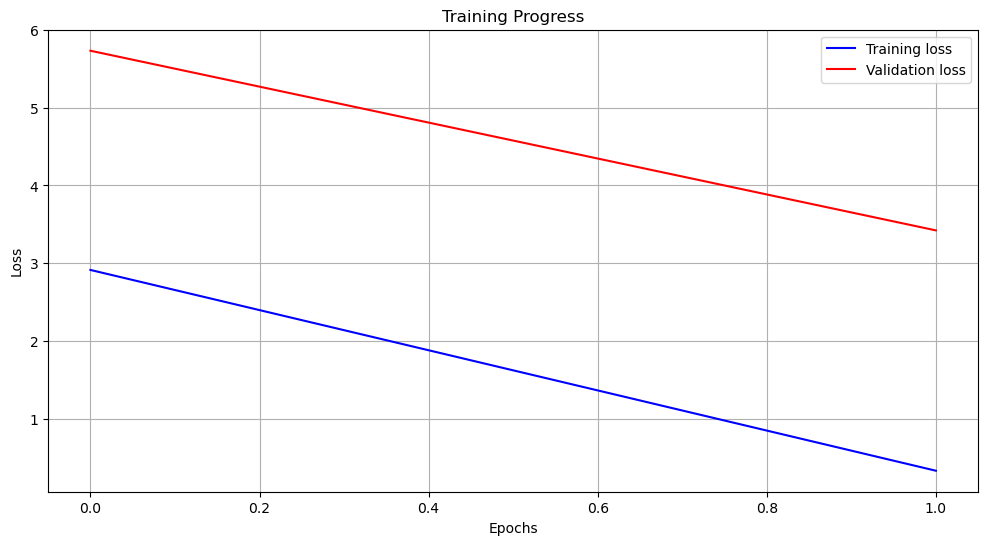

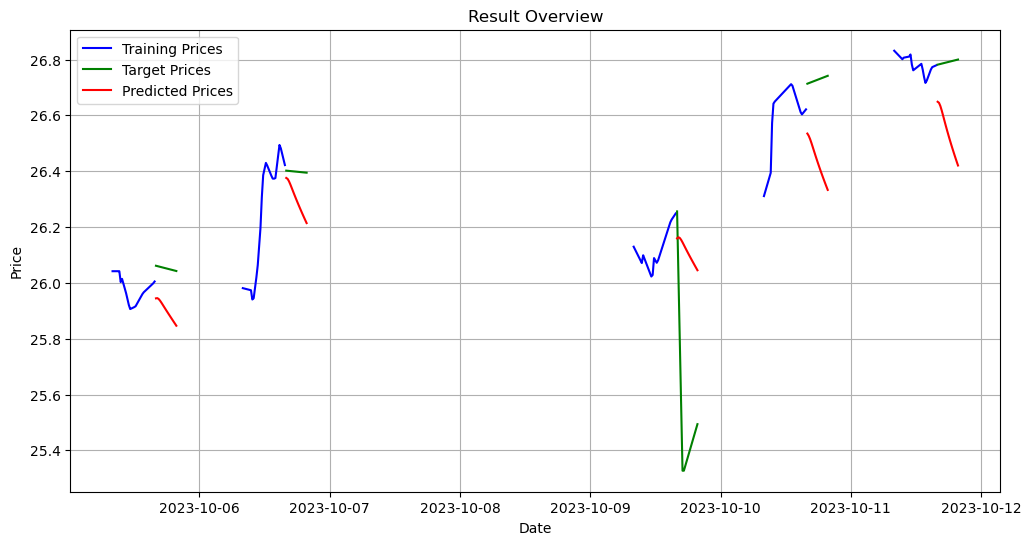

In [4]:
predictor_a2_1 = LSTMPredictor(sampling_rate_minutes=15,
                               price_csv_path=INTERPOLATED_PRICES / "2025-05-15 23_50_44  DAX Close Interpolated Prices at 15min from 2017-07-03 to 2025-04-30.csv",
                               daily_prediction_hour=16,
                               rolling_window_size=32,
                               forecast_horizon=16,
                               hidden_lstm_layer_size=128,
                               batch_size=64,
                               n_train_epochs=2,
                               forecast_step_loss_weight_range=(1, .7),  # slowly_decreasing, new default
                               model_save_directory=SAVED_MODELS)

100%|██████████| 1632/1632 [00:16<00:00, 97.73it/s] 


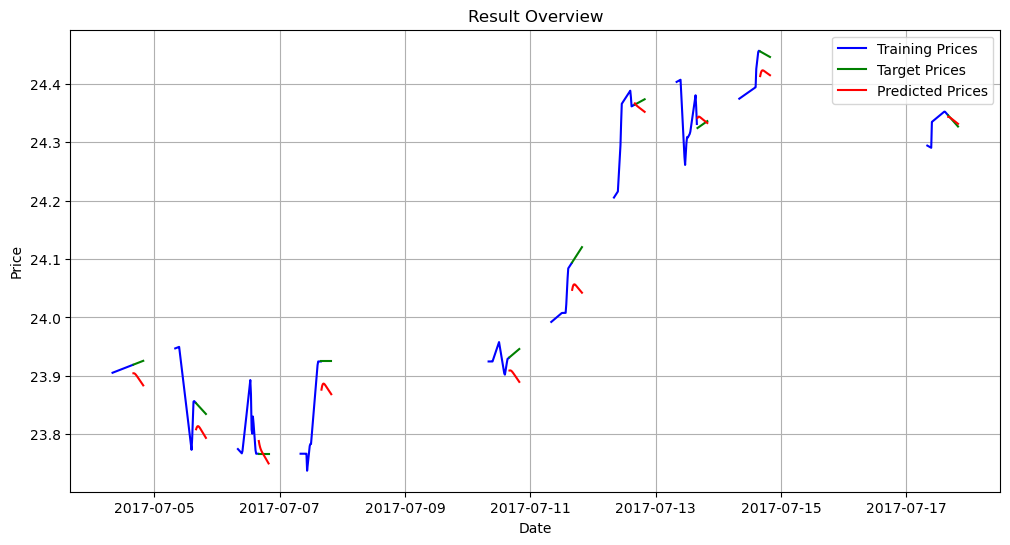

In [210]:
predictor_a2_1.plot_prediction_overview('training', (0,10))

Using CPU


Train loss: - | Val Loss: - | Patience 0/30 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Created rolling window view based on rolling_window_size of 32 and forecast_horizon of 16 with a time unit of 15 minutes.
Target values start at first observation after 16:00 daily.
Resulting dataset consists of 2041 observations.
Using last 20.0% of data for validation. Other data for training.
This yields 1632 training and 409 validation observations.


Train loss: 0.05591766518773511 | Val Loss: 3.3662132918834686  | Patience 29/30 | LRate: 6.25e-05 | Progress:  16%|█▌        | 32/200 [01:52<09:48,  3.50s/it] 


Early stopping triggered at validation loss of 3.461838811635971
Saving LSTM model to /Users/paulrusing/Library/Mobile Documents/com~apple~CloudDocs/PR iCloud/Work/Personal/Programming/Github Repos/hybrid-rl-index-trading/data/saved_models/2025-05-16 00_13_48 LSTM Model RW32 FH16 Layers3 Size128.pt.pt
Training finished. Plotting results for validation split:


100%|██████████| 409/409 [00:04<00:00, 92.98it/s]


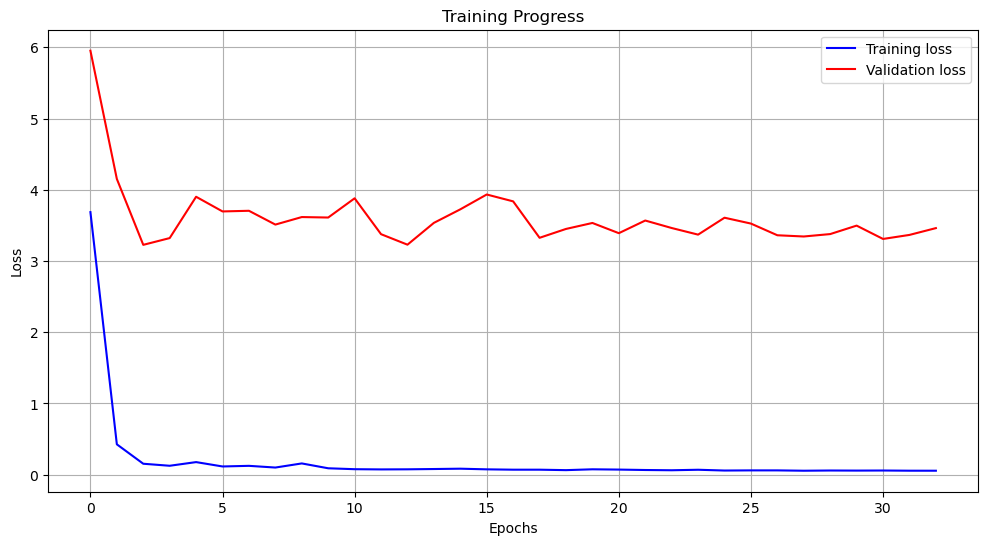

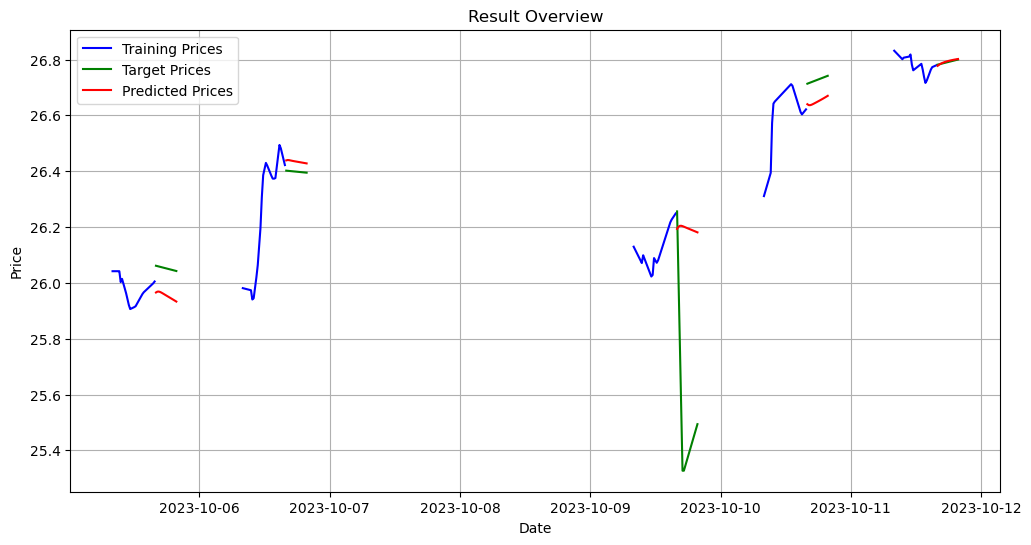

In [208]:
predictor_a2_2 = LSTMPredictor(sampling_rate_minutes=15,
                               price_csv_path=INTERPOLATED_PRICES / "2025-05-15 23_50_44  DAX Close Interpolated Prices at 15min from 2017-07-03 to 2025-04-30.csv",
                               daily_prediction_hour=16,
                               rolling_window_size=32,
                               forecast_horizon=16,
                               hidden_lstm_layer_size=128,
                               batch_size=64,
                               n_train_epochs=200,
                               forecast_step_loss_weight_range=(1, 1),  # equally weighted -> bad idea
                               model_save_directory=SAVED_MODELS)

100%|██████████| 1632/1632 [00:18<00:00, 87.72it/s]


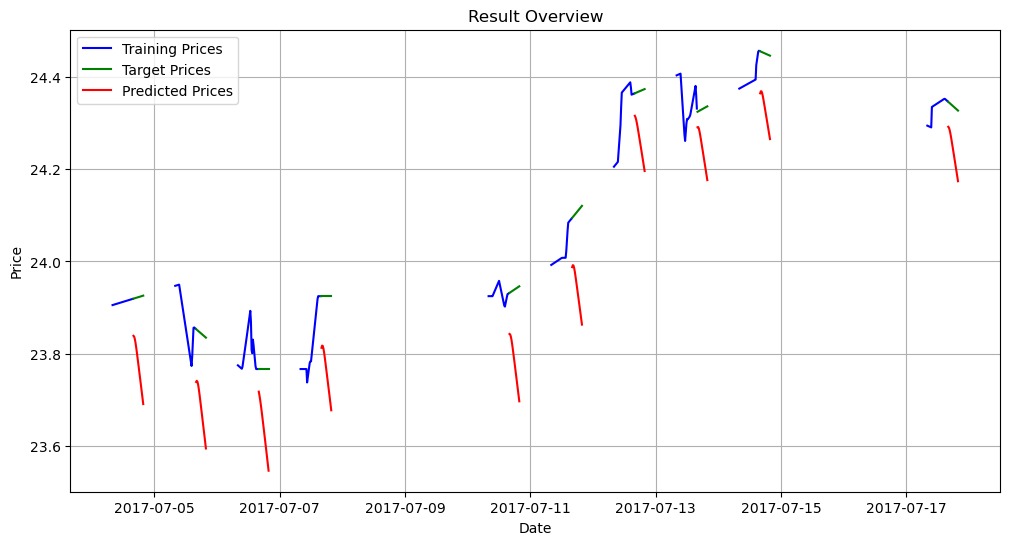

In [209]:
predictor_a2_2.plot_prediction_overview('training', (0,10))

Using CPU


Train loss: - | Val Loss: - | Patience 0/30 | LRate: - | Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Created rolling window view based on rolling_window_size of 32 and forecast_horizon of 16 with a time unit of 15 minutes.
Target values start at first observation after 16:00 daily.
Resulting dataset consists of 2041 observations.
Using last 20.0% of data for validation. Other data for training.
This yields 1632 training and 409 validation observations.


Train loss: 0.03618310997262597 | Val Loss: 2.5708976686000824  | Patience 29/30 | LRate: 6.25e-05 | Progress:  18%|█▊        | 37/200 [02:07<09:21,  3.45s/it] 


Early stopping triggered at validation loss of 2.5441057085990906
Saving LSTM model to /Users/paulrusing/Library/Mobile Documents/com~apple~CloudDocs/PR iCloud/Work/Personal/Programming/Github Repos/hybrid-rl-index-trading/data/saved_models/2025-05-16 00_05_04 LSTM Model RW32 FH16 Layers3 Size128.pt.pt
Training finished. Plotting results for validation split:


100%|██████████| 409/409 [00:04<00:00, 97.12it/s] 


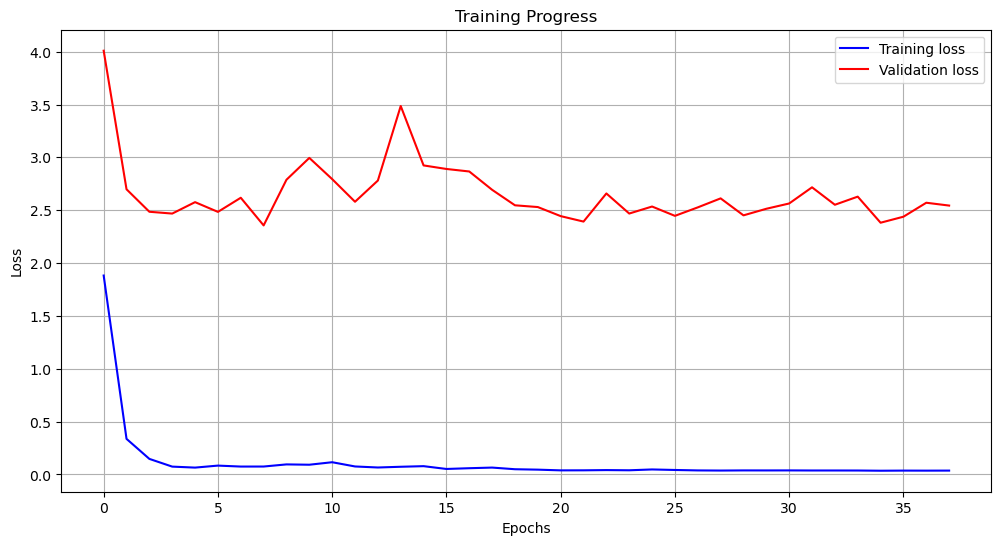

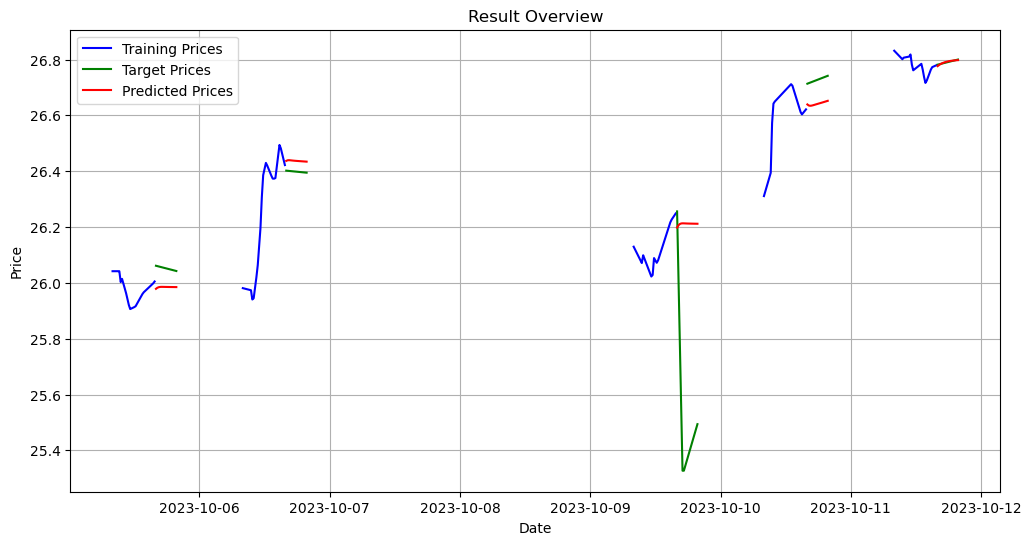

In [204]:
predictor_a2_3 = LSTMPredictor(sampling_rate_minutes=15,
                               price_csv_path=INTERPOLATED_PRICES / "2025-05-15 23_50_44  DAX Close Interpolated Prices at 15min from 2017-07-03 to 2025-04-30.csv",
                               daily_prediction_hour=16,
                               rolling_window_size=32,
                               forecast_horizon=16,
                               hidden_lstm_layer_size=128,
                               batch_size=64,
                               n_train_epochs=200,
                               forecast_step_loss_weight_range=(1, .4),  # default
                               model_save_directory=SAVED_MODELS)

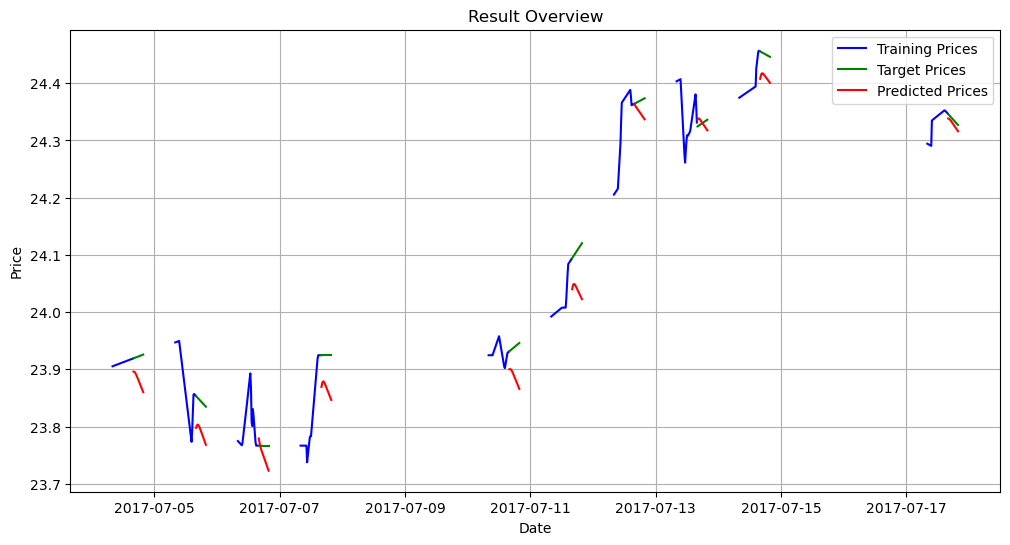

In [206]:
predictor_a2_1.plot_prediction_overview('training', (0, 10))

In [ ]:
predictor_a2_2

## Run

In [6]:
AV_API_KEY_FILE = ROOT / "private" / "Alpha Vantage API Key.txt"
with open(AV_API_KEY_FILE) as file: AV_API_KEY = file.read()

sampling_rate_minutes = 15
ticker = 'Dax'

In [7]:
ts = TimeSeries(key=AV_API_KEY, output_format='pandas')
recent_dax = ts.get_intraday(ticker, interval=f'{sampling_rate_minutes}min', outputsize="compact" if 14*60/sampling_rate_minutes < 100 else "full")
daily_dax = recent_dax[0][recent_dax[0].index.day_of_year == recent_dax[0].index.day_of_year.max()]['4. close']  # last day
recent_price_data = prep.time_interpolation_new_sampling_rate(daily_dax, '4. close', 'date', f'{sampling_rate_minutes}min', manual_operating_hours=(8, 22))
recent_price_data

,close
date,
2025-05-15 08:00:00,42.4200
2025-05-15 08:15:00,42.4600
2025-05-15 08:30:00,42.5000
2025-05-15 08:45:00,42.8500
2025-05-15 09:00:00,42.9500
2025-05-15 09:15:00,43.2300
2025-05-15 09:30:00,42.7473
2025-05-15 09:45:00,42.6800
2025-05-15 10:00:00,42.6850


In [9]:
isinstance(recent_price_data.index, pd.DatetimeIndex)

True

In [8]:
a1, b1, c1, d1 = predictor_a2_1.predict(recent_price_data[:predictor_a2_1.rolling_window_size])

E0516 15:04:17.820000 5231 site-packages/torch/_subclasses/fake_tensor.py:2388] [0/0] failed while attempting to run meta for aten.mm.default
E0516 15:04:17.820000 5231 site-packages/torch/_subclasses/fake_tensor.py:2388] [0/0] Traceback (most recent call last):
E0516 15:04:17.820000 5231 site-packages/torch/_subclasses/fake_tensor.py:2388] [0/0]   File "/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/torch/_subclasses/fake_tensor.py", line 2384, in _dispatch_impl
E0516 15:04:17.820000 5231 site-packages/torch/_subclasses/fake_tensor.py:2388] [0/0]     r = func(*args, **kwargs)
E0516 15:04:17.820000 5231 site-packages/torch/_subclasses/fake_tensor.py:2388] [0/0]   File "/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/torch/_ops.py", line 723, in __call__
E0516 15:04:17.820000 5231 site-packages/torch/_subclasses/fake_tensor.py:2388] [0/0]     return self._op(*args, **kwargs)
E0516 15:04:17.820000 5231 site-packages

TorchRuntimeError: Failed running call_function <built-in function linear>(*(FakeTensor(..., size=(1, 32)), Parameter(FakeTensor(..., size=(128, 1), requires_grad=True)), Parameter(FakeTensor(..., size=(128,), requires_grad=True))), **{}):
a and b must have same reduction dim, but got [1, 32] X [1, 128].

from user code:
   File "/var/folders/3v/jxzkml212_b_x_r_p9kg5n980000gn/T/ipykernel_5231/468053857.py", line 107, in forward
    temp_x = self.linear_1(x)  # we need to denote this as temp_x because we need the original input again in latter iterations
  File "/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/torch/nn/modules/linear.py", line 125, in forward
    return F.linear(input, self.weight, self.bias)

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


In [30]:
torch.empty(size=(lstm_input_matrix.shape[0], predictor_a2_1.forecast_horizon))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [34]:
lstm_input_matrix = np.expand_dims(recent_price_data, axis=0)[:, :predictor_a2_1.rolling_window_size, :]  # shape: batch_size (=1), sequence_length, features
assert lstm_input_matrix.shape[1] == predictor_a2_1.rolling_window_size, "Prediction input needs to be of shape (n_inputs, rolling_window_size, 1)"
predictor_a2_1.lstm_model(lstm_input_matrix)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [35]:
predictor_a2_1.lstm_model(torch.Tensor(lstm_input_matrix))

tensor([[0.5951, 0.6115, 0.6500, 0.6939, 0.7355, 0.7722, 0.8032, 0.8274, 0.8444,
         0.8554, 0.8623, 0.8674, 0.8716, 0.8755, 0.8791, 0.8823]],
       grad_fn=<SqueezeBackward1>)

In [29]:
type(daily_dax)

pandas.core.series.Series

In [26]:
recent_dax[0][recent_dax[0].index.day_of_year == recent_dax[0].index.day_of_year.max()]  # last day

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2025-05-15 19:15:00,42.6700,42.6700,42.6700,42.6700,55.0
2025-05-15 17:45:00,42.6400,42.6400,42.6400,42.6400,9.0
2025-05-15 17:30:00,43.0000,43.0000,42.9500,42.9500,101.0
2025-05-15 16:30:00,43.0000,43.0000,43.0000,43.0000,1.0
2025-05-15 16:00:00,42.7900,42.9200,42.7900,42.9200,174.0
2025-05-15 15:45:00,42.8100,42.8800,42.7100,42.7900,25140.0
2025-05-15 15:30:00,42.7700,42.8200,42.7700,42.8100,1973.0
2025-05-15 15:15:00,42.7900,42.8150,42.7600,42.8000,2883.0
2025-05-15 15:00:00,42.7600,42.8300,42.7600,42.7850,1018.0


In [19]:
import yfinance as yf

In [20]:
yf.download('DAX', )

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,DAX,DAX,DAX,DAX,DAX
Date,,,,,
2014-10-23,19.979094,19.994919,19.852493,19.852493,7400
2014-10-24,19.931622,19.931622,19.892058,19.892058,15200
2014-10-27,19.803440,19.803440,19.803440,19.803440,300
2014-10-28,20.184820,20.184820,20.129433,20.129433,3800
2014-10-29,20.311419,20.311419,20.303506,20.303506,13600
...,...,...,...,...,...
2025-05-09,42.825001,42.990002,42.700001,42.790001,86000
2025-05-12,42.380001,42.419998,41.900002,42.369999,262000
